# Analytics - query to reference mapping

This notebook is based on and adapted from this scvi-tools tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html

In [1]:
import scvi
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from pathlib import Path
import os
from scvi.hub import HubModel
import pynndescent
from PIL import ImageColor
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import gc
from scvi.data._download import _download

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

%load_ext autoreload
%autoreload 2

Global seed set to 1


## Citations

scArches:  
Mohammad Lotfollahi, Mohsen Naghipourfar, Malte D. Luecken, Matin Khajavi, Maren Büttner, Marco Wagenstetter, Žiga Avsec, Adam Gayoso, Nir Yosef, Marta Interlandi, Sergei Rybakov, Alexander V. Misharin, and Fabian J. Theis. Mapping single-cell data to reference atlases by transfer learning. Nature Biotechnology, 40(1):121–130, August 2021. doi:10.1038/s41587-021-01001-7.  

scANVI:  
Chenling Xu, Romain Lopez, Edouard Mehlman, Jeffrey Regier, Michael I Jordan, and Nir Yosef. Probabilistic harmonization and annotation of single-cell transcriptomics data with deep generative models. Molecular Systems Biology, January 2021. doi:10.15252/msb.20209620.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

## 1️⃣ Load the pre-trained model

Here we use the HLCA dataset.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C. et al. An integrated cell atlas of the lung in health and disease. Nat Med 29, 1563–1577 (2023). https://doi.org/10.1038/s41591-023-02327-2

Let's download the pre-trained model

In [3]:
local_dir = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref_old/temp_manual_3"

In [4]:
# hm = HubModel.pull_from_huggingface_hub(repo_name="scvi-tools/human-lung-cell-atlas", cache_dir=local_dir, revision="main")
model = scvi.model.SCANVI.load('/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref_old/temp_manual_3/HLCA_reference_model_minified')
# model_url = "https://huggingface.co/scvi-tools/human-lung-cell-atlas/resolve/main/model.pt"
# _download(model_url, local_dir, "model.pt")

INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref_old/temp_manual_3/HLCA_
         reference_model_minified/model.pt already downloaded                                                      


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_scanvi.py:58: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


## 2️⃣ Download the query data

For the query, we will use samples from the following publication:  

- Delorey, Toni M., et al. “COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets.” Nature 595.7865 (2021): 107-113.

In [5]:
%%capture
%%bash
curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz -o "query.h5.gz"
gzip -df query.h5.gz

In [6]:
geo_metadata_url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz"
metadata = pd.read_csv(geo_metadata_url, index_col=0)
query_data = sc.read_10x_h5("query.h5")

/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
query_data.var

,gene_ids,feature_types,genome
GRCh38___MIR1302-2HG,GRCh38___ENSG00000243485,Gene Expression,GRCh38
GRCh38___FAM138A,GRCh38___ENSG00000237613,Gene Expression,GRCh38
GRCh38___OR4F5,GRCh38___ENSG00000186092,Gene Expression,GRCh38
GRCh38___AL627309.1,GRCh38___ENSG00000238009,Gene Expression,GRCh38
GRCh38___AL627309.3,GRCh38___ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
SARSCoV2_SARSCoV2_ORF8,SARSCoV2_SARSCoV2_ORF8,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_N,SARSCoV2_SARSCoV2_N,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_ORF10,SARSCoV2_SARSCoV2_ORF10,Gene Expression,SARSCoV2
SARSCoV2_SARSCoV2_3prime,SARSCoV2_SARSCoV2_3prime,Gene Expression,SARSCoV2


In [8]:
# need gene ids as index to match the core HLCA data
query_data.var['gene_names'] = query_data.var.index
query_data.var.index = [idx.split("___")[-1] for idx in query_data.var.gene_ids]

In [9]:
# use metadata to select only cells of interest and remove empty drops
metadata = metadata.loc[metadata.donor == "D12_4",:].copy()
metadata.index = [idx.split("-")[-1] for idx in metadata.index]
# subset query_data to cells in metadata
query_data.obs.index = query_data.obs.index.str.rstrip("-1")
query_data = query_data[metadata.index, :].copy()

In [10]:
# add dataset information:
query_data.obs['dataset'] = "test_dataset_delorey_regev"

In [11]:
query_data

AnnData object with n_obs × n_vars = 1786 × 33567
    obs: 'dataset'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'

## 3️⃣ Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [12]:
# scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)
scvi.model.SCANVI.prepare_query_anndata(query_data, model)

INFO     Found 99.65% reference vars in query data.                                                                


/Users/valehvpa/GitRepos/scvi-tools/scvi/model/base/_archesmixin.py:222: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_padding = AnnData(


In [13]:
query_data.obs["scanvi_label"] = "unlabeled"

In [15]:
# query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")
query_model = scvi.model.SCANVI.load_query_data(query_data, model, accelerator = "cpu")

In [16]:
query_model.adata

AnnData object with n_obs × n_vars = 1786 × 2000
    obs: 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_names'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

Train the query model.

In [17]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [18]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="cpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/scvi-hub-clone/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 218/500:  44%|████▎     | 218/500 [01:45<02:16,  2.07it/s, v_num=1, train_loss_step=485, train_loss_epoch=497]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 543.482. Signaling Trainer to stop.


In [19]:
query_save_path = f"{local_dir}/query_model"
query_model.save(query_save_path, overwrite=True)

In [20]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

## 2️⃣ Learn a neighbors index on reference latent space  

Get the "latent space" from our embeddings. It is essentially just the mean of the latent distribution.

In [22]:
fname = "HLCA_full_v1.1_emb.h5ad"
adata = sc.read(os.path.join(local_dir, fname), backup_url=f"https://zenodo.org/record/7599104/files/{fname}")
adata = adata[adata.obs["core_or_extension"] == "core"].copy()

In [23]:
ref = adata.X
ref_nn_index = pynndescent.NNDescent(ref)
ref_nn_index.prepare()

## 6️⃣ Predict v2

Let's predict using a different cell type than we did earlier, as that is too coarse grained (compartment-level resolution).

In [24]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

In [25]:
def distances_to_affinities(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))
    weights = distances_tilda / np.sum(
        distances_tilda, axis=1, keepdims=True
    )
    return weights

# import numba
# @numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

weights = distances_to_affinities(ref_distances)

### 6️⃣.2️⃣ Predict cell types

In [26]:
label_key = "ann_level_3"
ref_cats = adata.obs[label_key].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(adata.obs[label_key].cat.categories)[p]
query_emb.obs["celltype_pred"], query_emb.obs["celltype_uncertainty"] = p, u

### 6️⃣.3️⃣ Evaluate predictions

Finally, let's evaluate predictions.

In [27]:
query_emb.obs[["celltype_pred", "celltype_uncertainty"]]

,celltype_pred,celltype_uncertainty
AAGCGTTTCAGTGCGC,Lymphatic EC mature,0.399992
AGCCACGAGGAGTCTG,Lymphatic EC mature,0.400032
ATCATTCGTATTTCGG,Lymphatic EC differentiating,0.200080
TGGCGTGCATGTAACC,Lymphatic EC mature,0.099996
CTACAGACACTGTGAT,EC venous,0.000000
...,...,...
TGATGCACATGGGCAA,AT1,0.000000
AATGACCAGCCGATTT,T cell lineage,0.000000
CTCCATGCACTCTAGA,Fibroblasts,0.000000
ATGGGTTAGAGGCGTT,AT1,0.099999


0.03359404708543523 5.960464477539063e-08


<AxesSubplot: ylabel='Density'>

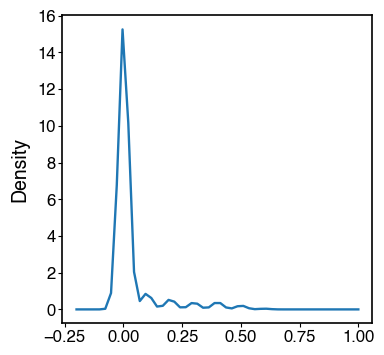

In [28]:
print(query_emb.obs["celltype_uncertainty"].mean(), np.quantile(query_emb.obs["celltype_uncertainty"], 0.75))
query_emb.obs["celltype_uncertainty"].plot(kind='density', ind=np.linspace(-0.2, 1))

## DEBUGGING

In [ ]:
# adata3 = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/cxg_raw_before_may_2023_update/adata.h5ad", backed=True)
# adata4 = anndata.read_h5ad("/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/temp_manual/backup/HLCA_reference.h5ad", backed=True)
# np.array_equal(adata2[idx1].X, adata4[idx1].obsm["X_scanvi_emb"])

In [ ]:
# p1 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/old/data_stuff/HLCA/hlca_new/HLCA_emb_and_metadata.h5ad"
# p2 = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/temp_manual/backup"
# adata1 = anndata.read_h5ad(p1)
# t = anndata.read_h5ad(os.path.join(p2, "HLCA_full_v1.1_emb.h5ad"))
# adata2 = t[t.obs["core_or_extension"] == "core"].copy()
# del t
# gc.collect()

In [ ]:
# idx1 = adata2.obs.index.difference(adata1.obs.index)
# idx2 = adata2.obs.index.difference(idx1)
# ann_2 = adata2.obs.loc[idx2]["ann_level_3"]
# ann_1 = adata1.obs.loc[idx2]["ann_level_3"]
# ann_1.name = "ann_1"
# ann_2.name = "ann_2"
# df = pd.concat([ann_1, ann_2], axis=1)
# df["ann_1,ann_2"] = df["ann_1"].astype("str") + "," + df["ann_2"].astype("str")
# # in 2 not in 1: 'Smooth muscle FAM83D+',
# # in 1 not in 2: 'Fibromyocytes',

In [ ]:
# df[ann_1.astype("str") != ann_2.astype("str")]["ann_1,ann_2"].value_counts()
# (adata2.X != model.adata.obsm["SCANVI_latent_qzm"]).sum()

In [207]:
lc = "/Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref"
model = scvi.model.SCANVI.load(os.path.join(lc, "temp_manual_backup/HLCA_reference_model_minified"))

INFO     File                                                                                                      
         /Users/valehvpa/GitRepos/scvi-hub-reproducibility/local/data_new/HLCA/query_to_ref/temp_manual_backup/HLCA
         _reference_model_minified/model.pt already downloaded                                                     


/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/Users/valehvpa/GitRepos/scvi-tools/scvi/data/fields/_scanvi.py:58: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [218]:
(model.adata.obsm["SCANVI_latent_qzm"] != adata.X).sum()

0

Conclusion: The bug was that the qzm that was being passed to the model before minification was not aligned to the observation (obs.index). Fixing that and re-running the hlca model minification and using that model fixed the issue (although I am still not sure where the "unaligned" qzm was being used that was causing the issue...). 
Despite the above, instead of building dependency on hugging face, and because we dont need the minified model here, I chose to just download model weights from hugging face, and the embeddings
(qzm only) from hlca's Zenodo.